In [56]:
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import random 
import os

In [57]:
df = pd.read_csv('ESC-50-master/meta/esc50.csv')
# Define categories and their sounds
categories = {
    'Animals': ['dog', 'cat'],
    'Natural soundscapes & water sounds': ['rain', 'sea_waves'],
    'Human sounds': ['coughing', 'footsteps', ],
    'Interior/domestic sounds': ['keyboard_typing', 'vacuum_cleaner',],
    'Exterior/urban noises': ['airplane', 'car_horn']
}
# Initialize dictionary to store sampled filenames for each category
sampled_sounds = {} 
 
# For each category, sample one sound from each subcategory
for category, sounds in categories.items():
    # Get all rows matching the sounds in this category
    category_df = df[df['category'].isin(sounds)]
    # Sample one from each sound type 
    samples = pd.concat([
        category_df[category_df['category'] == sound].sample(n=1)
        for sound in sounds
    ])
    # Store filenames in dictionary
    sampled_sounds[category] = samples['filename'].tolist()
    
print(sampled_sounds)




{'Animals': ['1-32318-A-0.wav', '4-161303-B-5.wav'], 'Natural soundscapes & water sounds': ['4-166661-A-10.wav', '3-187710-A-11.wav'], 'Human sounds': ['3-149042-A-24.wav', '2-209476-A-25.wav'], 'Interior/domestic sounds': ['3-144120-A-32.wav', '2-122820-A-36.wav'], 'Exterior/urban noises': ['2-96654-A-47.wav', '1-254507-A-43.wav']}


In [58]:
wave_list_data = [] 
base_path = 'ESC-50-master/audio/'
for category in sampled_sounds:
    for filename in sampled_sounds[category]:
        complete_path = os.path.join(base_path, filename)
        sample_rate, sound_data = wavfile.read(complete_path)
        wave_list_data.append((category, filename, sample_rate,sound_data))

/var/folders/hk/35r4d3px72v99cr1lfr8nw000000gn/T/ipykernel_11569/377107669.py:15: RuntimeWarning: divide by zero encountered in log10
  axes[idx].pcolormesh(t, f, 10 * np.log10(Sxx))


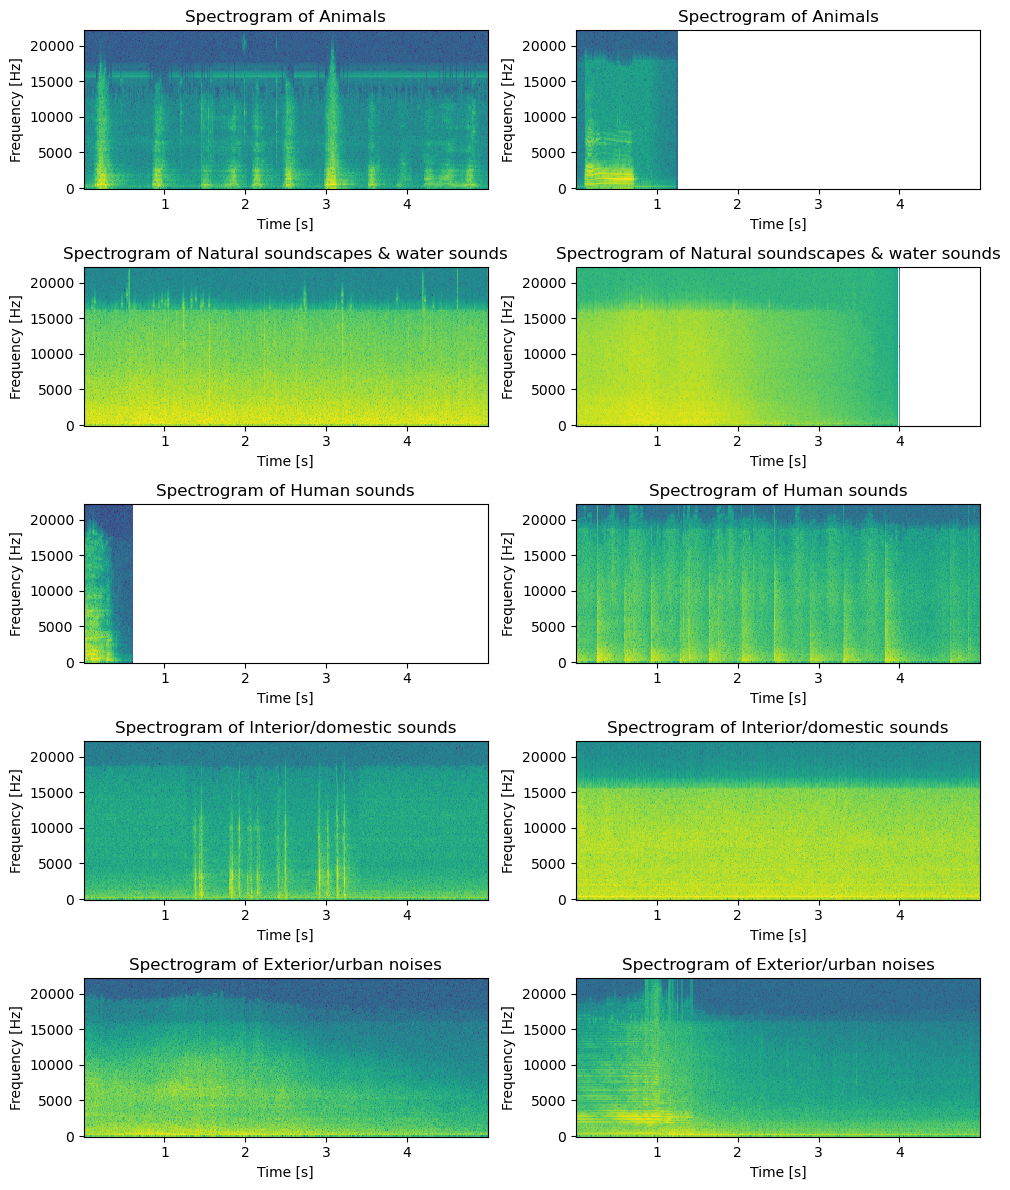

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
axes = axes.flatten()



for idx, wave in enumerate(wave_list_data):
    if idx >= len(axes):
        break

    wave_data = wave[3]
    category = wave[0]
    sample_rate = wave[2]

    f, t, Sxx = signal.spectrogram(wave_data, sample_rate)
    axes[idx].pcolormesh(t, f, 10 * np.log10(Sxx))
    axes[idx].set_title(f'Spectrogram of {category}')
    axes[idx].set_xlabel('Time [s]')
    axes[idx].set_ylabel('Frequency [Hz]')


    # axes[idx].hist(wave_data.flatten(), bins=100, color='blue', alpha=0.7)
    # axes[idx].set_title(f'Histogram of {category}')
    # axes[idx].set_xlabel('Amplitude')
    # axes[idx].set_ylabel('Frequency')
    # axes[idx].grid(True)
plt.tight_layout()
plt.show()